In [1]:
from nltk.corpus import brown
from nltk import ngrams
from nltk import FreqDist
import numpy as np
from collections import Counter

In [47]:
class BrownDataset(object):
    def __init__(self, include_start=True):
        self.words = brown.words()
        self.words = map(lambda x: x.lower(), self.words)
        self.total_word_cnt = len(self.words) + 2 * len(brown.sents())  # include START and END
        if include_start:
            self.words.append(u'START')
        self.words.append(u'END')
        self.vocab = set(self.words)


        self.vocab_len = len(self.vocab)
        self.word_to_idx = dict(zip(list(self.vocab), range(self.vocab_len)))

        self.sentences = []
        self.bigrams = []
        self.unigrams = []
        for sent in brown.sents():
            sentence = map(lambda x: x.lower(), sent)
            if include_start:
                sentence.insert(0, u'START')
            sentence.append(u'END')
            self.sentences.append(sentence)
            self.bigrams.extend(list(ngrams(sentence, 2)))
            self.unigrams.extend(sentence)

        self.unigram_freq = dict(Counter(self.unigrams))

        self.num_sentences = len(self.sentences)
        self.bigram_cnt = FreqDist(self.bigrams)
        self.bigram_len = len(self.bigram_cnt)
        self.bigram_idx = dict(zip(self.bigram_cnt.keys(), range(self.bigram_len)))
        self.bigram_freq = np.asarray(self.bigram_cnt.values())
        self.num_bigrams = len(self.bigram_cnt)

In [2]:
from __future__ import division
import numpy as np
import math


In [119]:
class LatentBigramModel:
    def __init__(self, dataset, num_classes=3, num_iterations=20, debug=False):
        self.dataset = dataset
        self.K = num_classes
        self.posterior = np.random.random(size=(dataset.num_bigrams, self.K))  # N x K
        self.w_to_hs_transition_prob = np.random.random(size=(dataset.vocab_len, self.K))  # V x K
        self.hs_to_w_emission_prob = np.random.random(size=(self.K, self.dataset.vocab_len))  # K x V
        self.iterations = num_iterations
        self.debug = debug


    def prob_word_given_ctxt(self, wprev, wnext):
        save = (wprev, wnext)
        wprev = self.dataset.word_to_idx[wprev]
        wnext = self.dataset.word_to_idx[wnext]
        ret = np.sum(self.w_to_hs_transition_prob[wprev] * self.hs_to_w_emission_prob[:, wnext])
        assert ret != 0, (save, self.w_to_hs_transition_prob[wprev], self.hs_to_w_emission_prob[:, wnext])
        return ret

    def log_prob_sentence(self, sentence):
        # Assuming START and END are included
        log_p = 0
        for i in range(len(sentence) - 1):
            log_p += math.log(self.prob_word_given_ctxt(sentence[i], sentence[i+1]))
        return log_p

    def prob_sentence(self, sentence):
        # Assuming START and END are included
        pr = 1
        for i in range(len(sentence) - 1):
            pr *= self.prob_word_given_ctxt(sentence[i], sentence[i + 1])
        return pr

    def marginal_log_likelihood(self):
        ll = 0
        for sentence in self.dataset.sentences:
            ll += self.log_prob_sentence(sentence)
        return ll/self.dataset.total_word_cnt

    def e_step(self):
        for bigram, freq in self.dataset.bigram_cnt.iteritems():
            wprev = self.dataset.word_to_idx[bigram[0]]
            wnext = self.dataset.word_to_idx[bigram[1]]
            unnorm_posterior_prob = self.w_to_hs_transition_prob[wprev] * self.hs_to_w_emission_prob[:, wnext]
            self.posterior[dataset.bigram_idx[bigram]] = unnorm_posterior_prob / np.sum(unnorm_posterior_prob)

    def m_step(self):
        cnt_category_bigram = self.posterior * self.dataset.bigram_freq[:, None]  # N x K
        idx = 0
        self.w_to_hs_transition_prob.fill(0)  # causes error for 'END' as it doesn't appear as first word in any bigram.
        self.w_to_hs_transition_prob[dataset.word_to_idx[u'END']].fill(1)
        self.hs_to_w_emission_prob.fill(0)  # causes error for 'START' as it doesn't apprear as second word in any bigram
        self.hs_to_w_emission_prob[:, self.dataset.word_to_idx[u'START']].fill(1)
        for bigram, freq in self.dataset.bigram_cnt.iteritems():
            wprev = self.dataset.word_to_idx[bigram[0]]
            self.w_to_hs_transition_prob[wprev] += cnt_category_bigram[idx]
            wnext = self.dataset.word_to_idx[bigram[1]]
            self.hs_to_w_emission_prob[:, wnext] += cnt_category_bigram[idx]
            idx += 1

        self.w_to_hs_transition_prob /= np.sum(self.w_to_hs_transition_prob, axis=1).reshape(-1, 1)
        self.hs_to_w_emission_prob /= np.sum(self.hs_to_w_emission_prob, axis=1).reshape(-1, 1)

        if self.debug:
            assert np.sum(np.abs(np.sum(cnt_category_bigram, axis=1) - self.dataset.bigram_freq)) < 1e-8, "Error"
            assert np.sum(np.abs(np.sum(self.w_to_hs_transition_prob, axis=1) - np.ones(dataset.vocab_len))) < 1e-8, "Error"
            assert np.sum(np.abs(np.sum(self.hs_to_w_emission_prob, axis=1) - np.ones(self.K))) < 1e-8, "Error"

    def em(self):
        mlls = []
        for iter in range(self.iterations):
            # E-step
            self.e_step()
            # M-step
            self.m_step()
            
            #Verification
            if self.debug:
                mll = self.marginal_log_likelihood()
                mlls.append(mll)
                print "iteration = ", iter, mll
        return mlls

In [4]:
dataset = BrownDataset()
latent_model = LatentBigramModel(dataset, num_classes=3, num_iterations=20, debug=True)
latent_model.em()

0 -0.397333980879
1 -6.52760231253
2 -6.49527196392
3 -6.45182927472
4 -6.39742714143
5 -6.34195682231
6 -6.29027978256
7 -6.24344570424
8 -6.20520692249
9 -6.1763753736
10 -6.15481328368
11 -6.13774688504
12 -6.12309511681
13 -6.10986052065
14 -6.09787107302
15 -6.08756595062
16 -6.07920035222
17 -6.07264628403
18 -6.06752601896
19 -6.06293356301


In [130]:
a = latent_model.prob_sentence(['START', 'colorless', 'green', 'ideas', 'sleep', 'furiously', 'END'])
b = latent_model.prob_sentence(['START', 'furiously', 'sleep', 'ideas', 'green', 'colorless', 'END'])
print a
print b
print a/b

6.05402072987e-06
0.000135589662616
0.000154592749699
7.3190067849e-06
2.08912893344e-05
1.16473248643e-11
3.86501485969e-07
7.1645210646e-06
6.60847529815e-06
8.1359630809e-06
5.37773272324e-08
0.093059452074
0.0
0.0
nan


/home/gauravanand25/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


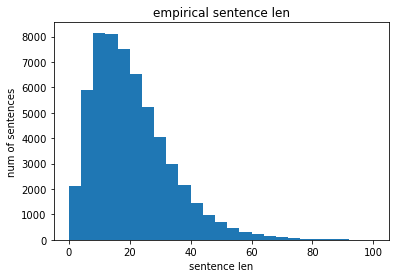

In [115]:
from matplotlib import pyplot as plt
sents_len = [len(x) for x in brown.sents()]
plt.title('empirical sentence len')
plt.xlabel('sentence len')
plt.ylabel('num of sentences')
plt.hist(sents_len, bins=25, range=[0, 100])
plt.show()

In [20]:
class UnigramMLEModel:
    def __init__(self, dataset, debug=False):
        self.debug = debug
        self.dataset = dataset

    def prob_word(self, word):
        ret = self.dataset.unigram_freq[word] / self.dataset.total_word_cnt
        assert ret != 0.0, word
        return  ret

    def log_prob_sentence(self, sentence):
        return sum([math.log(self.prob_word(word)) for word in sentence])

In [48]:
uni_dataset = BrownDataset(include_start=False)
uni_model = UnigramMLEModel(dataset)
print uni_model.log_prob_sentence(['colorless', 'green', 'ideas', 'sleep', 'furiously', 'END'])

-55.9237477771


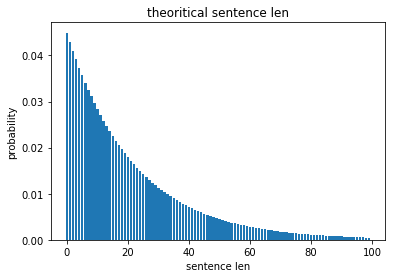

In [116]:
x = uni_model.prob_word(u'END')
model_sents_len = [(1-x)**n * x for n in range(100)]
plt.title('theoritical sentence len')
plt.xlabel('sentence len')
plt.ylabel('probability')
plt.bar(range(100), model_sents_len)
plt.show()

In [78]:
class BigramMLEModel:
    def __init__(self, dataset, debug=False):
        self.debug = debug
        self.dataset = dataset

    def prob_word_given_ctxt(self, nextw, prevw):
        ret = self.dataset.bigram_cnt[(prevw, nextw)] / self.dataset.unigram_freq[prevw]
        if ret == 0:
            print ("bigram freq = ", prevw, nextw, dataset.bigram_cnt[(prevw, nextw)])
            ret = 1e-10
        return ret

    def log_prob_sentence(self, sentence):
        # Assuming START and END are included
        log_p = 0
        for i in range(len(sentence) - 1):
            log_p += math.log(self.prob_word_given_ctxt(sentence[i + 1], sentence[i]))
        return log_p

In [81]:
bi_dataset = BrownDataset()
bi_model = BigramMLEModel(bi_dataset)

In [82]:
bi_model.log_prob_sentence(['START', 'colorless', 'green', 'ideas', 'sleep', 'furiously', 'END'])

('bigram freq = ', 'START', 'colorless', 0)
('bigram freq = ', 'colorless', 'green', 0)
('bigram freq = ', 'green', 'ideas', 0)
('bigram freq = ', 'ideas', 'sleep', 0)
('bigram freq = ', 'sleep', 'furiously', 0)
('bigram freq = ', 'furiously', 'END', 0)


-138.15510557964274

In [120]:
latent_model_1 = LatentBigramModel(dataset, num_classes=3, num_iterations=20, debug=True)
mlls1 = latent_model_1.em()

iteration =  0 -6.53150364026
iteration =  1 -6.50352095199
iteration =  2 -6.46898467936
iteration =  3 -6.42446123722
iteration =  4 -6.37753770704
iteration =  5 -6.33828626763
iteration =  6 -6.30708139529
iteration =  7 -6.28008546003
iteration =  8 -6.25527481155
iteration =  9 -6.23137393405
iteration =  10 -6.20757389222
iteration =  11 -6.18424122158
iteration =  12 -6.16323311778
iteration =  13 -6.14588466722
iteration =  14 -6.13182889679
iteration =  15 -6.11999308317
iteration =  16 -6.10962197897
iteration =  17 -6.1013529376
iteration =  18 -6.09498595367
iteration =  19 -6.08965904458


In [122]:
latent_model_2 = LatentBigramModel(dataset, num_classes=3, num_iterations=20, debug=True)
mlls2 = latent_model_2.em()

iteration =  0 -6.53138353432
iteration =  1 -6.50540915243
iteration =  2 -6.47412942329
iteration =  3 -6.43047722329
iteration =  4 -6.38453649874
iteration =  5 -6.34558368713
iteration =  6 -6.31004353369
iteration =  7 -6.27645946721
iteration =  8 -6.24554093327
iteration =  9 -6.21715793636
iteration =  10 -6.19111064069
iteration =  11 -6.16810555289
iteration =  12 -6.1490045734
iteration =  13 -6.13386622707
iteration =  14 -6.12229695884
iteration =  15 -6.11327017277
iteration =  16 -6.10573842076
iteration =  17 -6.0991117589
iteration =  18 -6.09328743565
iteration =  19 -6.08842879165


In [123]:
latent_model_3 = LatentBigramModel(dataset, num_classes=3, num_iterations=20, debug=True)
mlls3 = latent_model_3.em()

iteration =  0 -6.5188983431
iteration =  1 -6.48895625391
iteration =  2 -6.45496162059
iteration =  3 -6.41542126236
iteration =  4 -6.375901622
iteration =  5 -6.33780429231
iteration =  6 -6.30365622649
iteration =  7 -6.27599210245
iteration =  8 -6.25432405924
iteration =  9 -6.23676153338
iteration =  10 -6.22212518938
iteration =  11 -6.20981044506
iteration =  12 -6.19953969772
iteration =  13 -6.19131242677
iteration =  14 -6.18499537947
iteration =  15 -6.1799732962
iteration =  16 -6.17567531586
iteration =  17 -6.17188497597
iteration =  18 -6.16856175488
iteration =  19 -6.16592954049


In [124]:
print mlls1

[-6.531503640255804, -6.503520951987301, -6.4689846793642225, -6.4244612372170735, -6.377537707039707, -6.338286267633794, -6.307081395286071, -6.280085460028998, -6.255274811546983, -6.2313739340549565, -6.2075738922208314, -6.184241221583852, -6.16323311777931, -6.145884667223224, -6.131828896792912, -6.119993083165088, -6.1096219789744515, -6.101352937602872, -6.094985953666365, -6.089659044581166]


In [125]:
print mlls2

[-6.5313835343246565, -6.505409152434219, -6.474129423290645, -6.430477223292217, -6.384536498743343, -6.345583687129385, -6.310043533694446, -6.276459467205721, -6.245540933265708, -6.217157936357716, -6.191110640687326, -6.168105552886112, -6.149004573401932, -6.133866227069929, -6.122296958835761, -6.1132701727735945, -6.105738420760068, -6.0991117588965675, -6.093287435648416, -6.0884287916528]


In [126]:
print mlls3

[-6.51889834310279, -6.488956253907048, -6.454961620590298, -6.415421262357978, -6.375901622003498, -6.3378042923121995, -6.303656226487854, -6.275992102453064, -6.254324059235135, -6.2367615333827775, -6.222125189378138, -6.209810445058277, -6.199539697720396, -6.191312426766978, -6.18499537946734, -6.179973296199464, -6.175675315857544, -6.171884975969207, -6.168561754879815, -6.165929540489258]


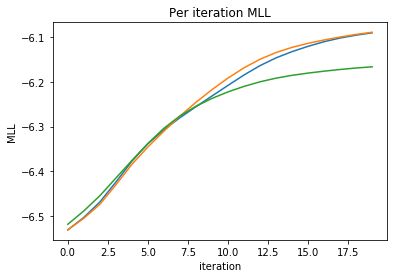

In [128]:
fig = plt.figure()
plt.plot(mlls1)
plt.plot(mlls2)
plt.plot(mlls3)
plt.title('Per iteration MLL')
plt.xlabel('iteration')
plt.ylabel('MLL')
plt.show()

In [135]:
a = latent_model_2.prob_sentence(['START', 'colorless', 'green', 'ideas', 'sleep', 'furiously', 'END'])
b = latent_model_2.prob_sentence(['START', 'furiously', 'sleep', 'ideas', 'green', 'colorless', 'END'])
print a
print b
print a/b

2.16751640791e-28
7.35368965244e-36
29475222.7841


In [132]:
a = latent_model_2.log_prob_sentence(['START', 'colorless', 'green', 'ideas', 'sleep', 'furiously', 'END'])
b = latent_model_2.log_prob_sentence(['START', 'furiously', 'sleep', 'ideas', 'green', 'colorless', 'END'])
print a
print b
print a/b

-63.6988006042
-80.897861167
0.787397833334


In [134]:
a = latent_model_1.prob_sentence(['START', 'colorless', 'green', 'ideas', 'sleep', 'furiously', 'END'])
b = latent_model_1.prob_sentence(['START', 'furiously', 'sleep', 'ideas', 'green', 'colorless', 'END'])
print a
print b
print a/b

1.02462928725e-31
1.5640923193e-28
0.00065509514663


In [136]:
a = latent_model_1.prob_sentence(['START', 'this', 'thing', "ain't", 'for', 'free', 'END'])
b = latent_model_1.prob_sentence(['START', 'free', 'thing', "ain't", 'for', 'this', 'END'])
print a/b

1.34198121097


In [138]:
a = latent_model_2.prob_sentence(['START', 'this', 'thing', "ain't", 'for', 'free', 'END'])
b = latent_model_2.prob_sentence(['START', 'free', 'thing', "ain't", 'for', 'this', 'END'])
print a/b

10.9628147941


In [139]:
a = latent_model_3.prob_sentence(['START', 'this', 'thing', "ain't", 'for', 'free', 'END'])
b = latent_model_3.prob_sentence(['START', 'free', 'thing', "ain't", 'for', 'this', 'END'])
print a/b

7.12647427918


In [143]:
a = latent_model_3.prob_sentence("START hope is the pillar of society END".split( ))
b = latent_model_3.prob_sentence("START pillar is the hope of society END".split( ))
print a/b

0.585807192054


In [144]:
a = latent_model_2.prob_sentence("START hope is the pillar of society END".split( ))
b = latent_model_2.prob_sentence("START pillar is the hope of society END".split( ))
print a/b

4.67959126927


In [145]:
a = latent_model_1.prob_sentence("START hope is the pillar of society END".split( ))
b = latent_model_1.prob_sentence("START pillar is the hope of society END".split( ))
print a/b

24.390631306


In [146]:
a = latent_model_3.prob_sentence("START society is the pillar of hope END".split( ))
b = latent_model_3.prob_sentence("START pillar is the hope of society END".split( ))
print a/b

2.48273452519


In [147]:
a = latent_model_2.prob_sentence("START society is the pillar of hope END".split( ))
b = latent_model_2.prob_sentence("START pillar is the hope of society END".split( ))
print a/b

17.4680360808


In [148]:
a = latent_model_1.prob_sentence("START society is the pillar of hope END".split( ))
b = latent_model_1.prob_sentence("START pillar is the hope of society END".split( ))
print a/b

6.04431071168


In [149]:
a = latent_model_3.prob_sentence("START satisfaction is the death of desire END".split( ))
b = latent_model_3.prob_sentence("START death is the satisfaction of desire END".split( ))
print a/b

0.686213089506


In [150]:
a = latent_model_2.prob_sentence("START satisfaction is the death of desire END".split( ))
b = latent_model_2.prob_sentence("START death is the satisfaction of desire END".split( ))
print a/b

0.425316598226


In [151]:
a = latent_model_1.prob_sentence("START satisfaction is the death of desire END".split( ))
b = latent_model_1.prob_sentence("START death is the satisfaction of desire END".split( ))
print a/b

0.792102919807


In [152]:
a = latent_model_3.prob_sentence("START satisfaction is the death of desire END".split( ))
b = latent_model_3.prob_sentence("START death is the desire of satisfaction END".split( ))
print a/b

0.214294883612


In [156]:
a = latent_model_2.prob_sentence("START satisfaction is the death of desire END".split( ))
b = latent_model_2.prob_sentence("START death is the desire of satisfaction END".split( ))
print a/b

10.1052835137


In [155]:
a = latent_model_1.prob_sentence("START satisfaction is the death of desire END".split( ))
b = latent_model_1.prob_sentence("START death is the desire of satisfaction END".split( ))
print a/b

0.669183623603


In [157]:
a = latent_model_3.prob_sentence("START desire is the death of satisfaction END".split( ))
b = latent_model_3.prob_sentence("START death is the satisfaction of desire END".split( ))
print a/b

1.09201110579


In [158]:
a = latent_model_2.prob_sentence("START desire is the death of satisfaction END".split( ))
b = latent_model_2.prob_sentence("START death is the satisfaction of desire END".split( ))
print a/b

0.00514241991898


In [159]:
a = latent_model_1.prob_sentence("START desire is the death of satisfaction END".split( ))
b = latent_model_1.prob_sentence("START death is the satisfaction of desire END".split( ))
print a/b

0.61520823218


In [160]:
a = latent_model_3.prob_sentence("START desire is the death of satisfaction END".split( ))
b = latent_model_3.prob_sentence("START death is the desire of satisfaction END".split( ))
print a/b

0.341020007338


In [161]:
a = latent_model_2.prob_sentence("START desire is the death of satisfaction END".split( ))
b = latent_model_2.prob_sentence("START death is the satisfaction of desire END".split( ))
print a/b

0.00514241991898


In [162]:
a = latent_model_1.prob_sentence("START desire is the death of satisfaction END".split( ))
b = latent_model_1.prob_sentence("START death is the satisfaction of desire END".split( ))
print a/b

0.61520823218


In [166]:
a = latent_model_1.prob_sentence("START she loves chocolate END".split( ))
b = latent_model_1.prob_sentence("START chocolate loves she END".split( ))
print a/b

619884246.243
